In [1]:
import torch 
import pyro
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.datasets import make_moons
import matplotlib

We generate $x_1,..., x_N$

In [18]:
from targets.conditional_density_estimation_target import Wave
target = Wave()

N_simulations = 50000
D_theta = target.sample_prior(N_simulations)
D_x = target.simulate(D_theta)

mu_theta = torch.zeros(1)
sigma_theta = torch.eye(1)
theta_prior_distribution = torch.distributions.MultivariateNormal(mu_theta, sigma_theta)
theta0 = theta_prior_distribution.sample()
theta0 = 0*torch.ones(1)

N_observations = 1
x0 = target.simulate(theta0.unsqueeze(0).repeat(N_observations,1))
x = torch.cat([D_theta, D_x], dim=1)
print(x.shape)
N = x.shape[0]

torch.Size([50000, 2])


We suppose that the data is generated according to the following sampling scheme:
- $w_1,...,w_K,... \sim GEM(\alpha)$ is a prior over mean and covariances
- $(\mu_1, \Sigma_1),..., (\mu_K,\Sigma_K),... \sim NIW(\mu_0, \lambda, \Psi, \nu)$ 
- $z_1,..., z_N \sim \sum_{k=1}^\infty w_k \delta_k$
- $x_i|z_i \sim N(\mu_{z_i}, \Sigma_{z_i})$

In [19]:
#prior_parameters
d=2
nu = 3
lbda = 0.01
mu = torch.mean(x, dim=0).float()
psi = torch.eye(d)/50
alpha = torch.tensor(10.)
truncation = 5

In [20]:
def sample_prior_parameters(num_samples):
    sigma = torch.inverse(torch.distributions.Wishart(nu,torch.inverse(psi)).sample([num_samples]))
    sigma = (sigma + torch.transpose(sigma, 1,2))/2
    mean = torch.distributions.MultivariateNormal(mu,scale_tril = torch.cholesky(sigma)/(lbda**(1/2))).sample()
    return mean, sigma

def repopulate_parameters(mean, sigma):
    _mean, _sigma = sample_prior_parameters(truncation)
    mean = torch.cat([mean, _mean], dim = 0)
    sigma = torch.cat([sigma, _sigma], dim = 0)
    return mean, sigma


In [21]:
import matplotlib
def plot_assignation(x,z):
    plt.scatter(x[:,0].numpy(), x[:,1].numpy(), c=z, cmap = matplotlib.cm.get_cmap('plasma'), alpha = .5)

def log_prob(new_x,z,mean,cov):
    unique, count = torch.unique(z, return_counts = True)
    weights = count/z.shape[0]
    distribution = torch.distributions.MixtureSameFamily(torch.distributions.Categorical(weights), torch.distributions.MultivariateNormal(mean, cov))
    return distribution.log_prob(new_x)

def plot_2d_function(f, x_min = -10,x_max = 10, y_min = -10, y_max = 10, delta = 50, levels = 2 , alpha = 0.7, new_figure = True):
    if new_figure :
        plt.figure(figsize = (10,10))
        plt.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
    tt_x = torch.linspace(x_min, x_max, delta)
    tt_y = torch.linspace(y_min,y_max, delta)
    mesh = torch.cartesian_prod(tt_x, tt_y)
    with torch.no_grad():
        plt.contourf(tt_x,tt_y,f(mesh).numpy().reshape(delta,delta).T, levels = levels, cmap = matplotlib.cm.get_cmap('viridis'), alpha = alpha)

In [22]:
Beta_distribution = torch.distributions.Beta(1, alpha)
def sample_weights(z): 
    counts = torch.unique(z, return_counts = True)[1]
    probs = torch.cat([counts,alpha.unsqueeze(-1)], dim = -1)
    w = torch.distributions.Dirichlet(probs).sample()
    r = w[-1]
    w_ = w[:-1]
    for i in range(truncation-1):
        v = Beta_distribution.sample()
        w = r*v
        r = r*(1-v)
        w_ = torch.cat([w_,w.unsqueeze(-1)], dim = -1)
    w_ = torch.cat([w_,r.unsqueeze(-1)], dim = -1)
    return w_

In [23]:
def sample_allocation(w, x, mean, cov): 
    w_i_k = w.unsqueeze(0).repeat(x.shape[0],1)
    p_i_k = torch.exp(torch.distributions.MultivariateNormal(mean, cov).log_prob(x.unsqueeze(1).repeat(1,w.shape[0],1)))
    temp = p_i_k*w_i_k
    return torch.distributions.Categorical(temp/ torch.sum(temp, dim = -1).unsqueeze(-1)).sample()


In [24]:
def equivalent_allocation(z, mean, cov):
    unique, inverse_index = torch.unique(z, return_inverse = True)
    new_mean = mean[unique]
    new_cov = cov[unique]
    return inverse_index, new_mean, new_cov

def sample_parameter_posterior(z,x):
    list_mean = []
    list_cov = []
    for c in torch.unique(z):
        x_c = x[z==c]
        N_c = x_c.shape[0]
        empirical_mean = torch.mean(x_c, dim =0)
        temp = (empirical_mean-mu).unsqueeze(-1)
        cov_c = torch.inverse(torch.distributions.Wishart(nu+N_c,torch.inverse(psi + (torch.cov(x_c.T)*(N_c-1) if N_c>=2 else torch.zeros(d)) + (lbda*N_c*temp@temp.T)/(lbda + N_c))).sample())
        cov_c = (cov_c + torch.transpose(cov_c,0,1))/2
        mean_c = torch.distributions.MultivariateNormal((lbda*mu + N_c*empirical_mean)/(lbda + N_c), scale_tril = torch.cholesky(cov_c)/(lbda + N_c)**(1/2)).sample()
        list_cov.append(cov_c.unsqueeze(0))
        list_mean.append(mean_c.unsqueeze(0))
    return torch.cat(list_mean, dim = 0), torch.cat(list_cov, dim = 0)

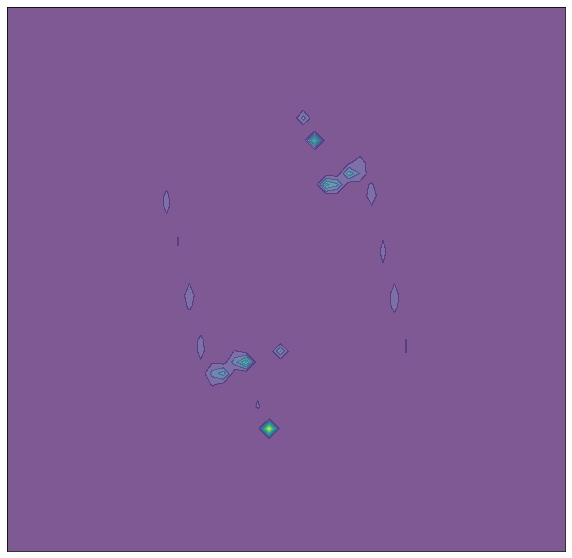

KeyboardInterrupt: 

In [25]:
z = torch.randint(size = [N], high = 1)
mean = torch.zeros(2).unsqueeze(0).repeat(1,1)
cov = torch.eye(2).unsqueeze(0).repeat(1,1,1)
while True:
    w = sample_weights(z)
    mean, cov = repopulate_parameters(mean, cov)
    z = sample_allocation(w, x, mean, cov)
    z, mean, cov = equivalent_allocation(z, mean, cov)
    print(mean.shape[0])
    mean, cov = sample_parameter_posterior(z,x)
    clear_output(wait=True)
    plot_2d_function(lambda samples: torch.exp(log_prob(samples,z, mean, cov)),x_min =torch.min(x[:,0])-0.25,x_max = torch.max(x[:,0])+0.25, y_min = torch.min(x[:,1])-0.25, y_max = torch.max(x[:,1])+0.25, levels = 10)
    plt.show()